# 만들어진 Doc2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\pc\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14883758371977377695
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4969044377
locality {
  bus_id: 1
}
incarnation: 10946100625587963883
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3, model4):
    print ('Logistic Regression')
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    print ('Random Forest')
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    print ('Kernel SVM')
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    print ('XGBoost')
    import xgboost as xgb
    fpr4, tpr4, thresholds4 = roc_curve(y, model4.predict(xgb.DMatrix(x)))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.plot(fpr4, tpr4, label='XGBoost')
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
import gensim
gensim.__version__

'3.3.0'

* windows에서 모델을 만들때 사용한 gensim의 버전이 3.3이었고, mac에서는 버전이 맞지 않아서 만들어둔 모델을 불러오지 못하였음.

## Doc2Vec

In [6]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags sentiment')

In [7]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [8]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [9]:
cores = int(multiprocessing.cpu_count() )
print (cores)

12


### twitter

#### Load Model

In [ ]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

#### Word to Vector

##### train set

In [ ]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_ct_train_for_doc2vec_sentiment_analysis.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis'):
    train_senti_y = [doc.sentiment for doc in tqdm(train)]
    
    pickle.dump(train_senti_y, open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','wb'))
    del train_senti_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_ct_for_sentiment_analysis'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_ct_for_sentiment_analysis','wb'))
    del train_tags_y

if 'train' in locals():
    del train

##### test set

In [ ]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_ct_test_for_doc2vec_sentiment_analysis.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis'):
    test_senti_y = [doc.sentiment for doc in tqdm(test)]
    
    pickle.dump(test_senti_y, open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','wb'))
    del test_senti_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_ct_for_sentiment_analysis'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_ct_for_sentiment_analysis','wb'))
    del test_tags_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d1000,n7,w10,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [ ]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m1)
train_x_by_m1_2 = scaling.transform(train_x_by_m1)
test_x_by_m1_2 = scaling.transform(test_x_by_m1)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1_2)))

In [ ]:
del scaling
del train_x_by_m1_2
del test_x_by_m1_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


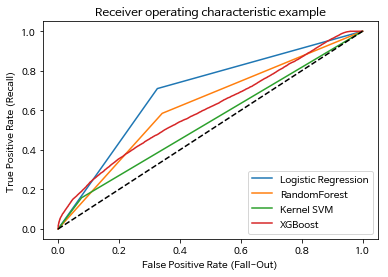

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 :  Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d1000,n7,w5,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

In [ ]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

#### 분류 모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m2)
train_x_by_m2_2 = scaling.transform(train_x_by_m2)
test_x_by_m2_2 = scaling.transform(test_x_by_m2)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2_2)))

In [ ]:
del scaling
del train_x_by_m2_2
del test_x_by_m2_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


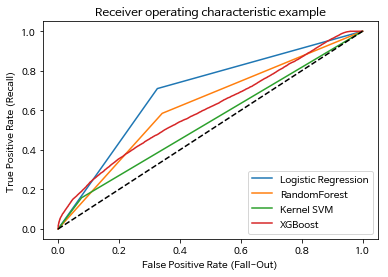

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

#### model3
* Doc2Vec(dbow,d1000,n7,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_ct_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_ct_for_sentiment_analysis','rb'))

In [ ]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

#### 분류 모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_b _m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m3)
train_x_by_m3_2 = scaling.transform(train_x_by_m3)
test_x_by_m3_2 = scaling.transform(test_x_by_m3)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3_2)))

In [ ]:
del scaling
del train_x_by_m3_2
del test_x_by_m3_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


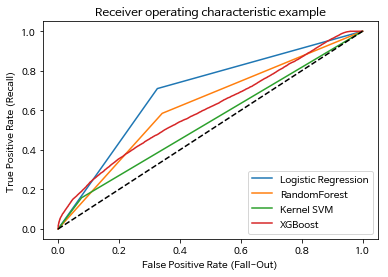

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

#### mecab

#### Load Model

In [ ]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-1000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

#### Word to Vector

##### train set

In [ ]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_mecab_train_for_doc2vec_sentiment_analysis','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis'):
    train_senti_y = [doc.sentiment for doc in tqdm(train)]
    
    pickle.dump(train_senti_y, open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','wb'))
    del train_senti_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_mecab_for_sentiment_analysis'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_mecab_for_sentiment_analysis','wb'))
    del train_tags_y

if 'train' in locals():
    del train

##### test set

In [ ]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_by_mecab_test_for_doc2vec_sentiment_analysis','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis'):
    test_senti_y = [doc.sentiment for doc in tqdm(test)]
    
    pickle.dump(test_senti_y, open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','wb'))
    del test_senti_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_mecab_for_sentiment_analysis'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_mecab_for_sentiment_analysis','wb'))
    del test_tags_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d1000,n7,w10,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [ ]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d1000-n7-w10-mc5-s0.001-t12-mecab'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m1)
train_x_by_m1_2 = scaling.transform(train_x_by_m1)
test_x_by_m1_2 = scaling.transform(test_x_by_m1)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1_2)))

In [ ]:
del scaling
del train_x_by_m1_2
del test_x_by_m1_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


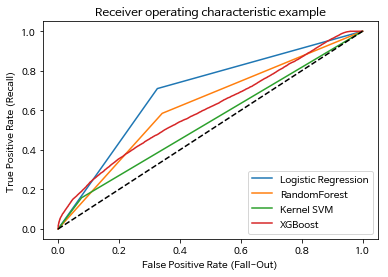

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d1000,n7,w5,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d1000-n7-w5-mc5-s0.001-t12-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
train_y2 = [y[0] for y in tqdm(train_y)]
test_y2 = [y[0] for y in tqdm(test_y)]

#### 분류 모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m2)
train_x_by_m2_2 = scaling.transform(train_x_by_m2)
test_x_by_m2_2 = scaling.transform(test_x_by_m2)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2_2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2_2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2_2)))

In [ ]:
del scaling
del train_x_by_m2_2
del test_x_by_m2_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


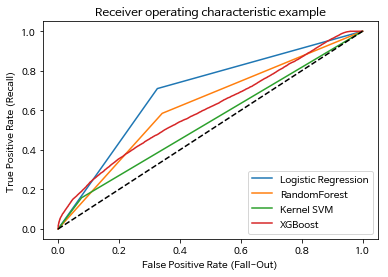

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name


#### model3
* Doc2Vec(dbow,d1000,n7,mc5,s0.001,t12)
* size-1000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_senti_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d1000-n7-mc5-s0.001-t12-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_senti_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 75, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m3)
train_x_by_m3_2 = scaling.transform(train_x_by_m3)
test_x_by_m3_2 = scaling.transform(test_x_by_m3)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3_2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3_2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3_2)))

In [ ]:
del scaling
del train_x_by_m3_2
del test_x_by_m3_2

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [37]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    'eval_metric' : 'auc', 
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.1,
    'nthread' : cores
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
test_acc = accuracy_score(y_test, test_class)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBOost_'+train_x_by_m1_name)

[0]	train-auc:0.607793	eval-auc:0.610414
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.620366	eval-auc:0.624268
[2]	train-auc:0.629444	eval-auc:0.634942
[3]	train-auc:0.633468	eval-auc:0.639657
[4]	train-auc:0.638111	eval-auc:0.642708
[5]	train-auc:0.641881	eval-auc:0.645733
[6]	train-auc:0.644185	eval-auc:0.648052
[7]	train-auc:0.646831	eval-auc:0.650695
[8]	train-auc:0.650333	eval-auc:0.653901
[9]	train-auc:0.653317	eval-auc:0.656875
[10]	train-auc:0.656777	eval-auc:0.660439
[11]	train-auc:0.658605	eval-auc:0.662213
[12]	train-auc:0.660999	eval-auc:0.664014
[13]	train-auc:0.663079	eval-auc:0.666033
[14]	train-auc:0.664794	eval-auc:0.667817
[15]	train-auc:0.665767	eval-auc:0.669134
[16]	train-auc:0.667282	eval-auc:0.670268
[17]	train-auc:0.669103	eval-auc:0.672211
[18]	train-auc:0.672656	eval-auc:0.675675
[19]	train-auc:0.674681	eval-auc:0.677895
[20]	train-auc:0.676836	eval-

[191]	train-auc:0.782306	eval-auc:0.768404
[192]	train-auc:0.782584	eval-auc:0.768594
[193]	train-auc:0.782716	eval-auc:0.76856
[194]	train-auc:0.78307	eval-auc:0.768706
[195]	train-auc:0.78344	eval-auc:0.769013
[196]	train-auc:0.783701	eval-auc:0.769175
[197]	train-auc:0.783974	eval-auc:0.769309
[198]	train-auc:0.784242	eval-auc:0.769435
[199]	train-auc:0.784381	eval-auc:0.769608
0.7696077384862317


Logistic Regression
Random Forest
Kernel SVM
XGBoost


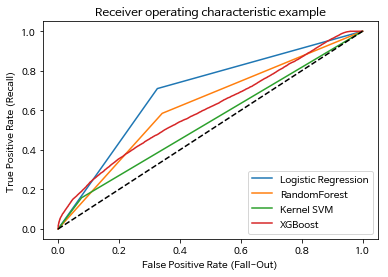

In [38]:
%%time
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

#### 분류모델 : Neural Network

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=300, batch_size = 250000,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train,epochs=300, batch_size = 250000,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name